In [1]:
import pandas as pd
import keras as ks
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import pickle
from google.colab import drive
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
import warnings
from keras.layers import Conv2D, Flatten, Dropout,MaxPooling2D
warnings.filterwarnings("ignore")
from keras.callbacks import History
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
x_train = "/content/drive/My Drive/Dataset/x_train.obj"
x_test = "/content/drive/My Drive/Dataset/x_test.obj"
y_train = "/content/drive/My Drive/Dataset/y_train.obj"

## Classification Task with a Full connected NN

In [0]:
with open("/content/drive/My Drive/Dataset/x_train.obj", 'rb') as x_train:
  x_train = pickle.load(x_train)
with open("/content/drive/My Drive/Dataset/x_test.obj", 'rb') as x_test:
  x_test = pickle.load(x_test)
with open("/content/drive/My Drive/Dataset/y_train.obj", 'rb') as y_train:
  y_train = pickle.load(y_train)

In [5]:
print("Numero totale di proprietà: "+str(x_train.shape[1]))
print("Esempi di training: "+str(x_train.shape[0]))
print("Esempi di test: "+str(x_test.shape[0]))
print("Livelli variabile target: " + str(y_train.shape[0]))

Numero totale di proprietà: 28
Esempi di training: 14000
Esempi di test: 8800
Livelli variabile target: 14000


In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,stratify=y_train, test_size=0.20)

In [0]:
#Data normalization: 
X_train = x_train/255
X_val = x_val/255
X_test = x_test/255

In [0]:
from imblearn.over_sampling import SMOTE
X_train, y_train = SMOTE().fit_resample(X_train.reshape(X_train.shape[0],28*28), y_train)

In [0]:
#X_train = X_train.reshape(X_train.shape[0],28*28)
X_test = X_test.reshape(X_test.shape[0],28*28)
X_val = X_val.reshape(X_val.shape[0], 28*28)
labels = ["P","Q","R","S","T","U","V","W","X","Y","Z"]
encoder = LabelEncoder()
encoder.fit(y_train)
Y_train = encoder.transform(y_train)
dummy_y = np_utils.to_categorical(Y_train)
Y_val = encoder.transform(y_val)
dummy_val = np_utils.to_categorical(Y_val)

In [31]:
np.unique(np.argmax(dummy_val, axis = 1))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [0]:
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1_l2
from keras import optimizers
from keras import regularizers
from keras.layers import LeakyReLU
sgd = optimizers.SGD(lr=0.1, decay=1e-4, momentum=0.9, nesterov=True)
hidd1 = [256,512,1024]
hidd2 = [128,256,512,1024]
hidd3 = [128,256,512]
funct_act = ["relu","tanh"]
funct_act2 = ["relu","tanh"]
lr = [0.01]
diz2 = {}
diz = {}
new_acc = 0
neurons = []
val = 0
restart = 0
conta = 0
for i in hidd1:
   for j in hidd2:
      for q in hidd3:
        for x in lr:
              sgd = optimizers.SGD(lr=x, decay=1e-4, momentum=0.9, nesterov=True)
              history2 = History()
              model2 = Sequential()
              model2.add(Dense(i, input_dim=X_train.shape[1],activation = "relu", kernel_regularizer=l1_l2(l1 = 0.00001, l2=0.0001)))
              if i == 64:
                model2.add(Dropout(0.3))
              elif j >= 128:
                model2.add(Dropout(0.5))
              model2.add(Dense(j,activation = "relu", kernel_regularizer=l1_l2(l1 = 0.0001, l2=0.001)))
              if j == 64:
                model2.add(Dropout(0.3))
              elif j >= 128:
                model2.add(Dropout(0.5))
              model2.add(Dense(q,activation = "relu", kernel_regularizer=l1_l2(l1 = 0.0001, l2=0.001)))
              if q == 64:
                model2.add(Dropout(0.3))
              elif q >= 128:
                model2.add(Dropout(0.5))
              model2.add(Dense(11, activation="softmax"))
              es = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
              model2.compile(loss='categorical_crossentropy',optimizer = sgd, metrics=['accuracy'])
              model2.fit(X_train, dummy_y, epochs=150, batch_size=512, callbacks=[history2],validation_data=(X_val,dummy_val), verbose=0)
              y_pred_mod2 = model2.predict_classes(X_val)
              acc_val = model2.evaluate(X_val, dummy_val, verbose = 0)[1]
              acc_train = model2.evaluate(X_train, dummy_y, verbose = 0)[1]
              if acc_val > val:
                diz["neurons"] = [i,j,q]
                diz["lr"] = x
                diz["validation_acc"]= acc_val
                diz["train_acc"] = acc_train
                diz2["sol{0}".format(conta)] = diz
                diz = {}
                conta = conta + 1
                val = acc_val
              print("Train accuracy: "+str(acc_train)+", Val accuracy: "+str(acc_val))
              print("Numero di neuroni usati in ordine di strato: " + "["+ str(i),str(j),str(q)+"]")
              print("Learning rate: ", str(x))
              print(classification_report(np.argmax(dummy_val, axis = 1), y_pred_mod2))

In [0]:
print(diz2)

{'sol0': {'neurons': [256, 128, 128], 'lr': 0.01, 'validation_acc': 0.9188095238095239, 'train_acc': 0.9817602779386219}, 'sol1': {'neurons': [256, 128, 256], 'lr': 0.01, 'validation_acc': 0.9247619047619048, 'train_acc': 0.9816637714726887}, 'sol2': {'neurons': [256, 256, 128], 'lr': 0.01, 'validation_acc': 0.9295238095238095, 'train_acc': 0.9804091874155568}, 'sol3': {'neurons': [512, 128, 128], 'lr': 0.01, 'validation_acc': 0.9297619047619048, 'train_acc': 0.9871646400308821}, 'sol4': {'neurons': [512, 128, 256], 'lr': 0.01, 'validation_acc': 0.9328571428571428, 'train_acc': 0.9883227176220807}, 'sol5': {'neurons': [1024, 128, 128], 'lr': 0.01, 'validation_acc': 0.9369047619047619, 'train_acc': 0.9909283922022776}, 'sol6': {'neurons': [1024, 128, 256], 'lr': 0.01, 'validation_acc': 0.9373809523809524, 'train_acc': 0.9921829762594094}}


In [0]:
from keras.regularizers import l1_l2
from keras import optimizers
from keras import regularizers
from keras.layers import LeakyReLU
from keras.initializers import glorot_normal
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
warnings.filterwarnings("ignore")
dec = [1e-3,1e-4,1e-5,1e-6]
drop = [0.3,0.4,0.45,0.5,0.55,0.6,0.65]
fBestModel = 'weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5' 
best_model = ModelCheckpoint(fBestModel, verbose=0, save_best_only=True)
sgd = optimizers.SGD(lr=0.1, decay=1e-3, momentum=0.9, nesterov=True)
history2 = History()
model2 = Sequential()
model2.add(Dense(256, input_dim=X_train.shape[1], activation ="relu", kernel_regularizer=l1_l2(l1 = 0.0001, l2=0.001), kernel_initializer = glorot_normal()))
model2.add(Dropout(0.5))
model2.add(Dense(128,kernel_initializer = glorot_normal(),kernel_regularizer=l1_l2(l1 = 0.0001, l2=0.001), activation ="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(11, activation="softmax"))
es = EarlyStopping(monitor='val_loss', patience=40, verbose=0)
model2.compile(loss='categorical_crossentropy',optimizer = sgd, metrics=['accuracy'])
model2.fit(X_train, dummy_y, epochs=200, batch_size=512, callbacks=[history2, es, best_model],validation_data=(X_val,dummy_val), verbose=1)
acc_val = model2.evaluate(X_val, dummy_val, verbose = 0)
acc_train = model2.evaluate(X_train, dummy_y, verbose = 0)
y_pred_mod2 = model2.predict_classes(X_val)
#print(classification_report(np.argmax(dummy_val, axis = 1), y_pred_mod2))

In [15]:
model2.load_weights('/content/drive/My Drive/best_model2.h5')
acc_val = model2.evaluate(X_val, dummy_val, verbose = 0)
acc_train = model2.evaluate(X_train, dummy_y, verbose = 0)
print(acc_val,acc_train)
#model2.save_weights('best_model2.h5')

[0.32247017758233204, 0.9775] [0.31865122833437703, 0.9767029627753862]


In [0]:
y_pred_mod2 = model2.predict_classes(X_train)
c = classification_report(np.argmax(dummy_y, axis = 1), y_pred_mod2)

In [17]:
 d = print(c)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1077
           1       0.97      0.97      0.97      1077
           2       0.98      0.97      0.98      1077
           3       0.99      0.99      0.99      1077
           4       0.98      0.99      0.98      1077
           5       0.95      0.97      0.96      1077
           6       0.93      0.96      0.95      1077
           7       0.99      0.98      0.99      1077
           8       1.00      0.97      0.98      1077
           9       0.97      0.95      0.96      1077
          10       0.99      0.99      0.99      1077

    accuracy                           0.98     11847
   macro avg       0.98      0.98      0.98     11847
weighted avg       0.98      0.98      0.98     11847



In [0]:
d

In [0]:
predictions = model2.predict(X_test).argmax(axis=-1)+np.array([16])

In [0]:
#np.savetxt('/content/drive/My Drive/Lorenzo_Famiglini_838675_score2_2.txt', predictions, fmt='%i')

In [511]:
model2.predict(X_test).argmax(axis=-1)[1010:1020]

array([ 7, 10,  5,  1, 10,  6, 10,  4,  6,  7])

In [509]:
np.unique(model2.predict(X_test).argmax(axis=-1))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

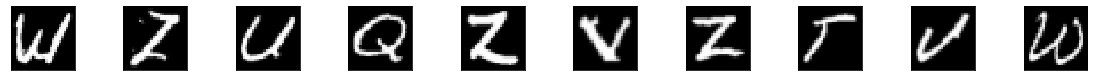

In [512]:
plt.figure(figsize=(40, 4))
for i in range(10):
    # display original
    ax = plt.subplot(3, 20, i+1)
    plt.imshow(X_test[i+1010].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [427]:
dummy_val

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


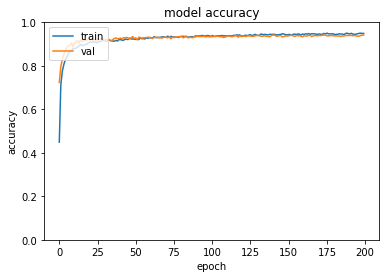

In [26]:
#Plot accuracy
axes = plt.axes()
axes.set_ylim([0,1])
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('model_acc.png')

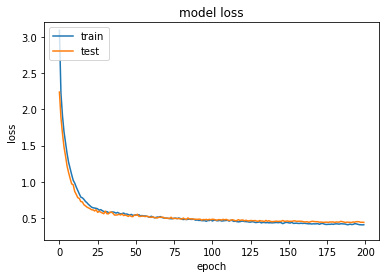

In [32]:
#Plot loss
axes = plt.axes()
axes.set_ylim([0.2,3.2])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss_model.png')

La cifra nell'immagine è un 16


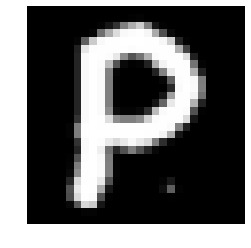

In [0]:
#Visualizzazione lettere 
plt.imshow(X_train[36].reshape([28,28]), cmap="gray")
plt.axis('off') # rimuoviamo i valori sulle assi 
print("La cifra nell'immagine è un %d" % y_train[36])

## AUTOENCODER TASK:

In [0]:
with open("/content/drive/My Drive/Dataset/x_train.obj", 'rb') as x_train:
  x_train = pickle.load(x_train)
with open("/content/drive/My Drive/Dataset/x_test.obj", 'rb') as x_test:
  x_test = pickle.load(x_test)
with open("/content/drive/My Drive/Dataset/y_train.obj", 'rb') as y_train:
  y_train = pickle.load(y_train)

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,stratify=y_train, test_size=0.30)

In [0]:
#Data normalization: 
X_train = x_train/255
X_val = x_val/255
X_test = x_test/255

In [0]:
from imblearn.over_sampling import SMOTE
X_train, y_train = SMOTE().fit_resample(X_train.reshape(X_train.shape[0],28*28), y_train)

In [0]:
X_val = X_val.reshape(X_val.shape[0], 28*28)

In [0]:
from keras.layers import Input
from keras.models import Model
input_img= Input(shape=(784,))

In [0]:
from keras import regularizers
input_img = Input(shape=(784,))
encoded = Dense(256, activation='relu')(input_img)
encoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(784, activation='sigmoid')(decoded)
encoder = Model(input_img, encoded)
decoder = Model(input_img,decoded)

In [70]:
autoencoder = Model(input_img, decoded)
sgd = optimizers.SGD(lr=0.1, decay=1e-4, momentum=0.9, nesterov=True)
autoencoder.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['mae'])
autoencoder.fit(X_train,X_train,
                epochs=200,
                batch_size=512,
                shuffle=False,
                validation_data=(X_val, X_val),verbose = 0)

In [71]:
encoded_imgs = encoder.predict(X_val)
predicted = autoencoder.predict(X_val)
autoencoder.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_32 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_33 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_34 (Dense)             (None, 784)               201488    
Total params: 468,368
Trainable params: 468,368
Non-trainable params: 0
_________________________________________________________________


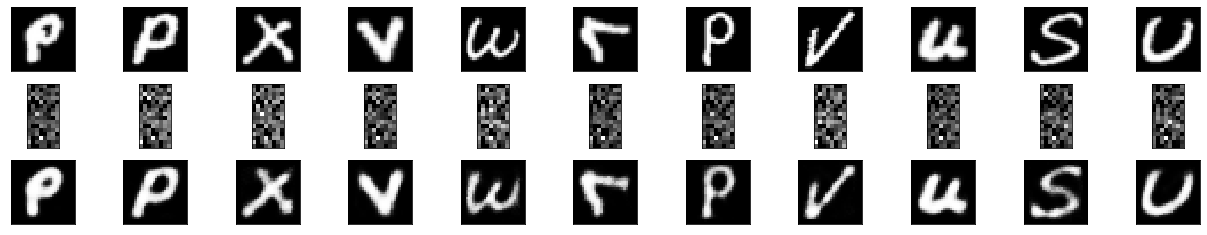

In [72]:
plt.figure(figsize=(40, 4))
for i in range(11):
    # display original
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(X_val[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded image
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(encoded_imgs[i].reshape(16,8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #display reconstruction
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(predicted[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
plt.savefig("autoencoder_result.png")    
plt.show()

## Autoencoder + Classification Task

In [0]:
sgd = optimizers.SGD(lr=0.1, decay=1e-4, momentum=0.9, nesterov=True)
input_img= Input(shape=(784,))
def encoder(input_img):
  encoded = Dense(256, activation = 'relu')(input_img)
  encoded = Dense(128, activation='relu')(encoded)
  return encoded

def decoder(encoded):
  decoded = Dense(784, activation='sigmoid')(encoded)
  return decoded

In [0]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='binary_crossentropy', optimizer = sgd)
autoencoder.summary()

In [0]:
autoencoder_train = autoencoder.fit(X_train,X_train,epochs=300,
                batch_size=512,
                shuffle = True,
                validation_data=(X_val, X_val),verbose = 0)

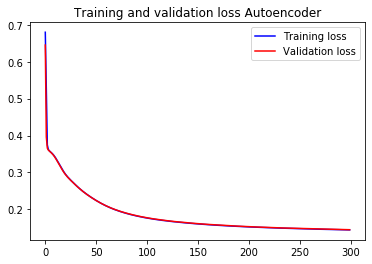

In [76]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(300)
plt.figure()
plt.plot(epochs, loss, 'b', color = 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss Autoencoder')
plt.legend()
plt.show()

In [0]:
autoencoder.save_weights('autoencoder.h5')

In [0]:
encoder_label = LabelEncoder()
encoder_label.fit(y_train)
Y_train = encoder_label.transform(y_train)
dummy_y = np_utils.to_categorical(Y_train)
Y_val = encoder_label.transform(y_val)
dummy_val = np_utils.to_categorical(Y_val)

In [0]:
from keras.regularizers import l1_l2
def fc(enco):
    den = Dense(128, activation='relu',kernel_regularizer=l1_l2(l1 = 0.0001, l2=0.01))(enco)
    den = Dropout(0.4)(den)
    den = Dense(64, activation = 'relu',kernel_regularizer=l1_l2(l1 = 0.0001, l2=0.01))(den)
    den = Dropout(0.5)(den)
    out = Dense(11, activation='softmax')(den)
    return out

In [0]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [0]:
for l1,l2 in zip(full_model.layers[:2],autoencoder.layers[0:2]):
    l1.set_weights(l2.get_weights())
for layer in full_model.layers[0:2]:
    layer.trainable = False

In [0]:
full_model.compile(loss="categorical_crossentropy", optimizer=sgd,metrics=['accuracy'])

In [94]:
full_model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_44 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_45 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0  

In [0]:
classify_train = full_model.fit(X_train, dummy_y, epochs=200, batch_size=512,validation_data=(X_val,dummy_val), verbose=0)

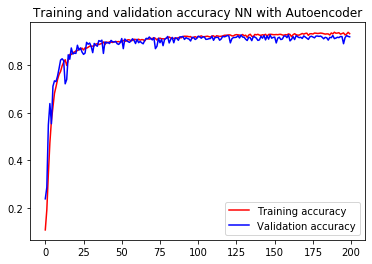

In [96]:
accuracy = classify_train.history['acc']
val_accuracy = classify_train.history['val_acc']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', color = 'red',label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy NN with Autoencoder')
plt.legend()
plt.savefig("Class_autoenc_acc.png")

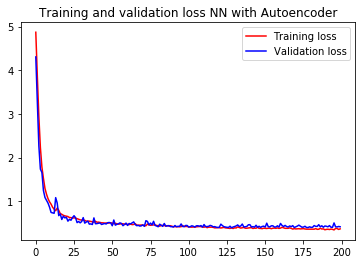

In [97]:
plt.plot(epochs, loss, 'b',color ='red',label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss NN with Autoencoder')
plt.legend()
plt.savefig("Class_autoenc_loss1.png")

In [0]:
y_pred_mod2 = full_model.predict(X_train)
print(classification_report(np.argmax(dummy_y, axis = 1), np.argmax(y_pred_mod2, axis = 1)))

In [0]:
full_model.evaluate(X_train,dummy_y)

In [0]:
full_model.evaluate(X_val, dummy_val)

In [0]:
#full_model.load_weights('best_model2_autoencoder.h5')